In [2]:
from loguru import logger
import pandas as pd
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb
from itertools import product
from botwenger.modeling.train import Train

from botwenger.config import PROCESSED_DATA_DIR, PROCESSED_DATA_FILENAME_1, PROCESSED_DATA_FILENAME_8

2025-09-13 12:45:46.922 | INFO     | botwenger.config:<module>:11 - PROJ_ROOT path is: /home/victu/botwenger
/home/victu/miniforge3/envs/botwenger/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.3, 0.5, 0.8],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

# Prepare all combinations
param_combinations = list(product(
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['min_child_weight'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
))

data = Train.loading_features_data(f"{PROCESSED_DATA_DIR}/{PROCESSED_DATA_FILENAME_1}")

target_column = "prediction_target_puntuacion_media_roll_avg"
split_column = "season"
player_column = "player"
feature_columns = [col for col in data.columns if col not in [target_column, split_column, player_column]]

X = data[feature_columns]
y = data[target_column]

train_mask = data[split_column].isin([2024,2025])
test_mask = data[split_column]==2025
val_mask = data[split_column]==2024

X_train, y_train = X[~train_mask], y[~train_mask]

X_val, y_val = X[val_mask], y[val_mask] 

X_test, y_test = X[test_mask], y[test_mask] 

best_rmse = float('inf')
best_params = None

2025-09-13 12:26:21.687 | INFO     | __main__:loading_features_data:16 - Loading features data...
2025-09-13 12:26:21.731 | INFO     | __main__:loading_features_data:18 - Loaded features data


In [30]:
for max_depth, learning_rate, min_child_weight, subsample, colsample_bytree in param_combinations:

        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=1000,
            learning_rate=learning_rate,
            eval_metric="rmse",
            early_stopping_rounds=50,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
            n_jobs=-1,
            tree_method="gpu_hist"
        )
        
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            verbose = False
        )

    
        y_pred = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {
                'max_depth': max_depth,
                'learning_rate': learning_rate,
                'min_child_weight': min_child_weight,
                'subsample': subsample,
                'colsample_bytree': colsample_bytree
            }

/home/victu/miniforge3/envs/botwenger/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [12:26:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1757348053364/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/home/victu/miniforge3/envs/botwenger/lib/python3.10/site-packages/xgboost/core.py:2652: UserWarning: [12:26:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1757348053364/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/victu/miniforge3/envs/botwenger/lib/python3.10/site-packages/xgboost/callback.py:386

2025-09-13 12:45:55.845 | INFO     | botwenger.modeling.train:loading_features_data:88 - Loading features data...


2025-09-13 12:45:55.893 | INFO     | botwenger.modeling.train:loading_features_data:90 - Loaded features data


/home/victu/miniforge3/envs/botwenger/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [12:45:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1757348053364/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/home/victu/miniforge3/envs/botwenger/lib/python3.10/site-packages/xgboost/core.py:2652: UserWarning: [12:45:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1757348053364/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


Beta RMSE Val: 2.9182
Beta R^2 Val: 0.2417


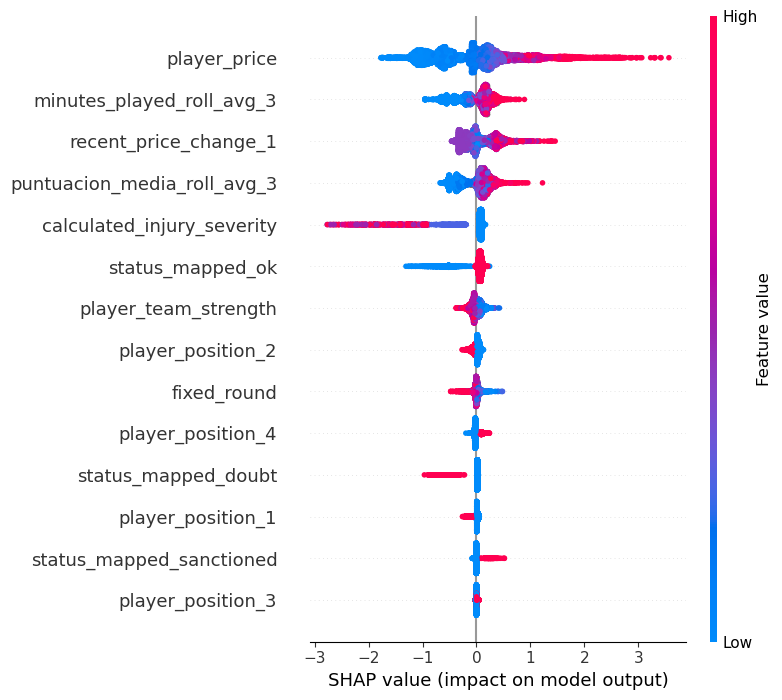

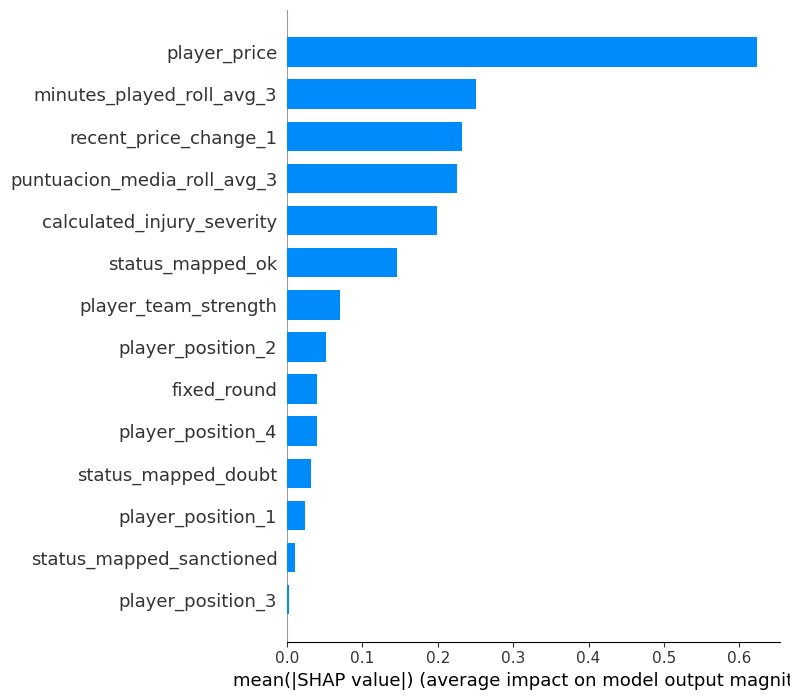

Beta RMSE Test: 2.9185
Beta R^2 Test: 0.2428


In [4]:
Train.main()